In [255]:
%load_ext autoreload

%autoreload 2

import campie
from countrycrab import compiler, heuristics,cosmetics
import os
import matplotlib.pyplot as plt
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"]="1,2,3,4,5,6,7"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [256]:
!pip install ray[tune]

Defaulting to user installation because normal site-packages is not writeable


# Get the solution

In [179]:
%%time
module_path = os.path.abspath(os.path.join(".."))
config = {'instance': module_path +'/data/datasets/3sat/uf20-91/uf20-03.cnf',          
          'heuristic': 'GNSAT',
         'compiler':'compile_GNSAT',
         'noise':0.7,
          'max_runs':25,
         'max_flips': 100}

p_vs_it_g, violated_constr_mat, inputs, (ts_g, p_vs_t_g) = solver.solve(config = config,params = config)

CPU times: user 3.85 s, sys: 32.1 ms, total: 3.88 s
Wall time: 3.88 s


In [202]:
for n in range(25):
    if violated_constr_mat[n,-3]==0:
        solution = inputs[n,:]
        break

In [207]:
architecture, params = compiler.compile_MNSAT(config, params)
tcam =  architecture[0]
ram = architecture[1]
check = np.sum(campie.tcam_match((1-solution).reshape(1,20), tcam))
if check==0:
    print("correct solution")

correct solution


In [208]:
check

array(0)

# Look at energy minimization

In [311]:
module_path = os.path.abspath(os.path.join(".."))
config = {'instance': module_path +'/data/datasets/3sat/uf20-91/uf20-02.cnf',  
    "mode": "energy", # Use k-SAT mode for getting the number of violated constraints as output
    "update_mode": "random", # spins are updated one at a time in random way. Also supports "sequential" and "stochastic_group"
    # "num_groups": 10,  # Number of groups to randomly assign variables to for parallel updates
    
    # Noise and annealing settings
    "noise": 1.5,                                    # Initial noise amplitude
    "final_noise": 0.0,                            # Final noise amplitude
    "threshold": 0.0,                              # Decision threshold
    "annealing_schedule": "linear",                # "linear", "exponential", "geometric", "logarithmic"
    # "cooling_rate": 0.95,                          # For geometric schedule
    "representation": "binary",
}

params = {
    "max_runs": 100,                               # Number of parallel instances
    "max_flips": 1000,                             # Maximum iterations
    "noise_distribution": "normal"                 # "normal", "uniform", "intrinsic"
}

In [312]:
%%time
architecture, params = compiler.compile_memHNN(config, params)
results = heuristics.memHNN(architecture, config, params)

CPU times: user 11.2 s, sys: 0 ns, total: 11.2 s
Wall time: 11.2 s


Text(0, 0.5, 'Mean Energy')

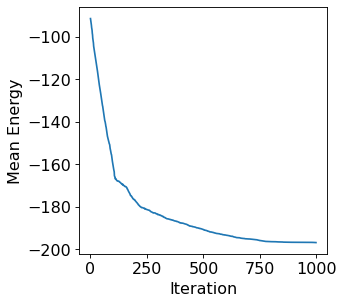

In [313]:
plt.plot(results[0].get().mean(axis = 0));
plt.xlabel('Iteration')
plt.ylabel('Mean Energy')

Text(0, 0.5, 'Energy')

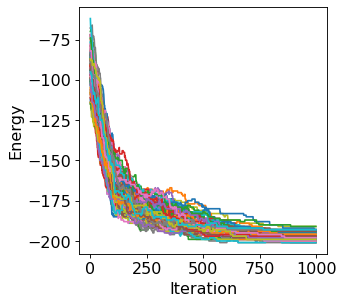

In [314]:
plt.plot(results[0].get().T);
plt.xlabel('Iteration')
plt.ylabel('Energy')

In [294]:
# # Get QUBO parameters from architecture - ensure all are CuPy arrays
# W = architecture[0]
# B = architecture[1]
# C = float(architecture[2])
# #binary_inputs = (spin_inputs + 1) / 2
# spin_solution = (2*((1-solution))-1)
# n_vars = len(spin_solution)
# best_energy = -0.5 * np.sum(spin_solution * (spin_solution @ W[0:n_vars,0:n_vars])) - np.sum(B[0:n_vars] * spin_solution) - C

In [235]:
print(f"not clear how to convert the best energy = {best_energy} to the one with auxiliary variables")

not clear how to convert the best energy = -24.0 to the one with auxiliary variables


The energy is effectively minimized

# Retrieve number of violated clauses per iteration (mode = "k-SAT")

In [370]:
module_path = os.path.abspath(os.path.join(".."))
config = {'instance': module_path +'/data/datasets/3sat/uf20-91/uf20-02.cnf',  
    "mode": "k-SAT", # Use k-SAT mode for getting the number of violated constraints as output
    "update_mode": "stochastic_group", # spins are updated one at a time in random way. Also supports "sequential" and "stochastic_group"
    "num_groups": 10,  # Number of groups to randomly assign variables to for parallel updates
    
    # Noise and annealing settings
    "noise": 2.8,                                    # Initial noise amplitude
    "final_noise": 0.0,                            # Final noise amplitude
    "threshold": 0.0,                              # Decision threshold
    "annealing_schedule": "linear",                # "linear", "exponential", "geometric", "logarithmic"
    # "cooling_rate": 0.95,                          # For geometric schedule
    "representation": "binary",
}

params = {
    "max_runs": 1000,                               # Number of parallel instances
    "max_flips": 500,                             # Maximum iterations
    "noise_distribution": "normal"                 # "normal", "uniform", "intrinsic"
}

In [371]:
%%time
architecture, params = compiler.compile_memHNN(config, params)
results = heuristics.memHNN(architecture, config, params)

CPU times: user 2.19 s, sys: 0 ns, total: 2.19 s
Wall time: 2.18 s


Text(0, 0.5, 'Mean violated clauses')

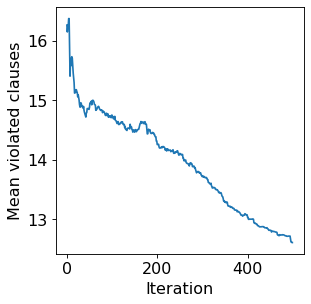

In [372]:
plt.plot(results[0].get().mean(axis = 0));
plt.xlabel('Iteration')
plt.ylabel('Mean violated clauses')

Text(0, 0.5, 'Violated clauses')

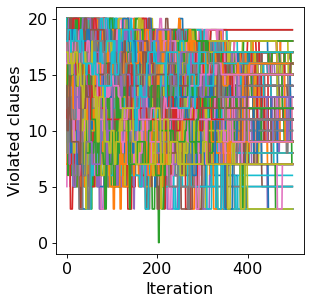

In [373]:
plt.plot(results[0].get().T);plt.xlabel('Iteration')
plt.ylabel('Violated clauses')